# Sage vs TDB2

This benchmark compares the performance of **TDB2 query engine** vs **Sage query engine** on **WatDiv**: a dataset of roughly 10 millions of triples and 192 SPARQL queries.

It was run with `openjdk 19.0.2` on a Macbook pro 2021 running macOS Ventura version 13.0.1; with a M1 Pro CPU 10 cores; GPU 16 cores; 16 Go RAM; 1 To SSD.

The results of the benchmark were saved in `.csv` files. This rest of this notebook only aims to display them in a pleasant manner.

In [1]:
!pip3 install pandas --quiet --disable-pip-version-check

import pandas as pd
import os

def readFiles(filters = [""]):
    title_to_csv = {}
    for filename in os.listdir():
        if filename.endswith(".csv") and any([filter in filename for filter in filters]):
            try:
                title_to_csv[filename] = pd.read_csv(filename)
            except:
                print(f"Error while reading {filename}, skipping…")
    return title_to_csv

print(f"Just read all {len(readFiles())} files…") # default read all
print(f"Just read {len(readFiles(['Short']))} short experiment files…")
print(f"Just read {len(readFiles(['Short', 'Sage']))} short or Sage experiment files…")

Just read all 12 files…
Just read 4 short experiment files…
Just read 10 short or Sage experiment files…


## Short queries

Sage's most impactful feature is about providing users with complete results. Short queries, ie. queries with an execution below the second, are already executed entirely. We only want to confirm that Sage does not negatively impact performance in the most favorable setting.

WatdivBenchmark-TDB force order-Short.csv
WatdivBenchmark-Sage force order 1s-Short.csv
WatdivBenchmark-Sage force order 1ms-Short.csv
WatdivBenchmark-Sage force order 30s-Short.csv
WatdivBenchmark-TDB force order-Short.csv
WatdivBenchmark-Sage force order 1s-Short.csv
WatdivBenchmark-Sage force order 1ms-Short.csv
WatdivBenchmark-Sage force order 30s-Short.csv


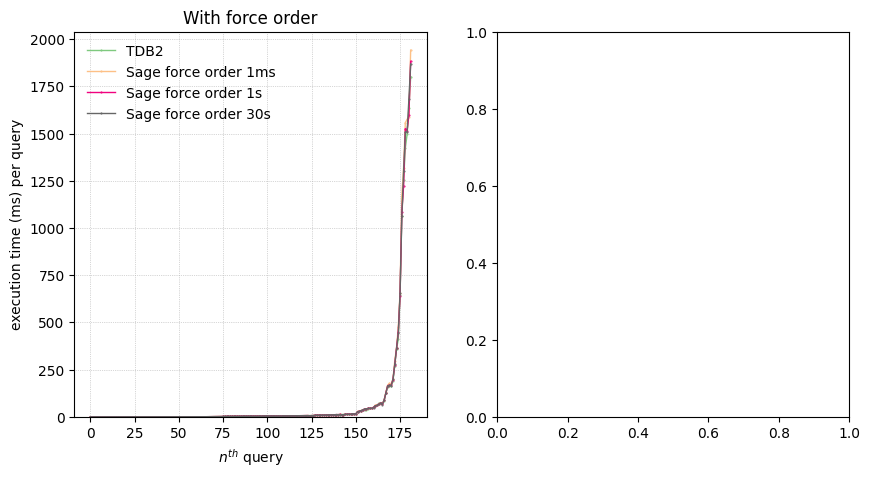

In [2]:
!pip3 install matplotlib --quiet --disable-pip-version-check
## %matplotlib ## `plt.show()` and `df.plot()` work better, maybe issue with macOS

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


title_to_csv = readFiles(["Short"])

## format the column score as float
def columnToFloat(df, column):
    if df[column].dtypes != "float64":
        df[column] = df[column].str.replace(',', '.').astype(float)
        
def allColumnsToFloat(dfs, column):
    for title in dfs.keys():
        columnToFloat(dfs[title], column)
        
allColumnsToFloat(title_to_csv, "Score")

## remove single short ("ss") values, only keep averaged
def keepOnlyMode(df, mode = "avgt"):
    return df.loc[df["Mode"] == mode]

def allAndOnlyMode(dfs, mode = "avgt"):
    for title in dfs.keys():
        dfs[title] = keepOnlyMode(dfs[title], mode)
        
allAndOnlyMode(title_to_csv)

## Sort ASC by score
def sortByColumn(df, column):
    df.sort_values(by=[column], inplace=True)
    df.reset_index(drop = True, inplace = True)

def merge(df1, df2, name):
    second = df2[['Score', "Param: a_query"]]
    second = second.rename(columns={"Score": name})
    df1 = df1.merge(second, on="Param: a_query", how='left')
    return df1

def baseline(dfs, filters = [""], filters_out = None):
    df = pd.DataFrame()
    base = "TDB2"    
    for title in dfs.keys():
        print(title)
        if filters_out != None and any([filter in title for filter in filters_out]):
            continue
        elif "TDB" in title and any([filter in title for filter in filters]):
            df = dfs[title][['Score', "Param: a_query"]]
            df = df.rename(columns={"Score": base})
    
    if len(df) == 0:
        return df;
    
    for title in sorted(dfs.keys()):
        if filters_out != None and any([filter in title for filter in filters_out]) or "TDB" in title:
            continue 
        elif any([filter in title for filter in filters]):
            df = merge(df, dfs[title][['Score', "Param: a_query"]], title.split("-")[1])
    sortByColumn(df, base)
    return df

no_force_order_df = baseline(title_to_csv, [""], ["force order"])

force_order_df = baseline(title_to_csv, ["force order"])

def plotGraphs(dfs = [], titles = [], unit="ms"):
    colormap = "Accent"
    fig, axes = plt.subplots(nrows=1, ncols=len(dfs), figsize=(10, 5))

    column = 0
    for title, df in zip(titles, dfs):
        if len(df) == 0:
            continue
        axis = df.plot(ax=axes[column] if len(dfs)>1 else axes, # multiplot
                       grid=True, lw=1, colormap=colormap, marker='.', markersize=1,
                       title=title)
        axis.set_xlabel("$n^{th}$ query")
        axis.set_ylabel(f"execution time ({unit}) per query")
        
        axis.xaxis.grid(linestyle="dotted", linewidth=0.5)
        axis.yaxis.grid(linestyle="dotted", linewidth=0.5)
        
        axis.legend(frameon=False)
        
        left,right = axis.get_ylim()
        axis.set_ylim(0, right)
        column = column + 1
        
        # no ticks below 1 on the x-axis
        major_tick_locs = axis.xaxis.get_majorticklocs()
        if len(major_tick_locs) < 2 or major_tick_locs[len(major_tick_locs)-1] - major_tick_locs[len(major_tick_locs)-2] < 1:
            axis.xaxis.set_major_locator(mticker.MultipleLocator(1))

plotGraphs([no_force_order_df, force_order_df], ["Without force order", "With force order"])


For fast **Watdiv** queries the execution time of which is below the second without force order, the plot shows that **TDB2** and **Sage** are on par. We suspect that small variations are the result of the JVM and OS not being exactly in the same state during benchmarking: Java is notoriously difficult to benchmark, and even `jmh` is not a silverbullet.

We expected such results as Sage is but slightly different from TDB2 when queries are below the set timeout. For these queries, only the longest queries above 1 second actually trigger 1 pause/resume. Since pausing/resuming is efficient, it does not show.

Now, what happens on longer queries, ie. executing between 1s and 100s? 

## Medium queries

Watdiv does not provide numerous such queries. The execution mode is slightly different for this benchmark since we cannot afford to run thousands of time an operation (eg. to trigger all *JIT* optimization). The benchmark does singleshot measurements after few warmups round. Take a look at the Java class for more details on the setting.

WatdivBenchmark-Sage force order 30s-Medium.csv
WatdivBenchmark-TDB force order-Medium.csv
WatdivBenchmark-Sage force order 1s-Medium.csv
WatdivBenchmark-Sage force order 1ms-Medium.csv
WatdivBenchmark-Sage force order 30s-Medium.csv
WatdivBenchmark-TDB force order-Medium.csv
WatdivBenchmark-Sage force order 1s-Medium.csv
WatdivBenchmark-Sage force order 1ms-Medium.csv


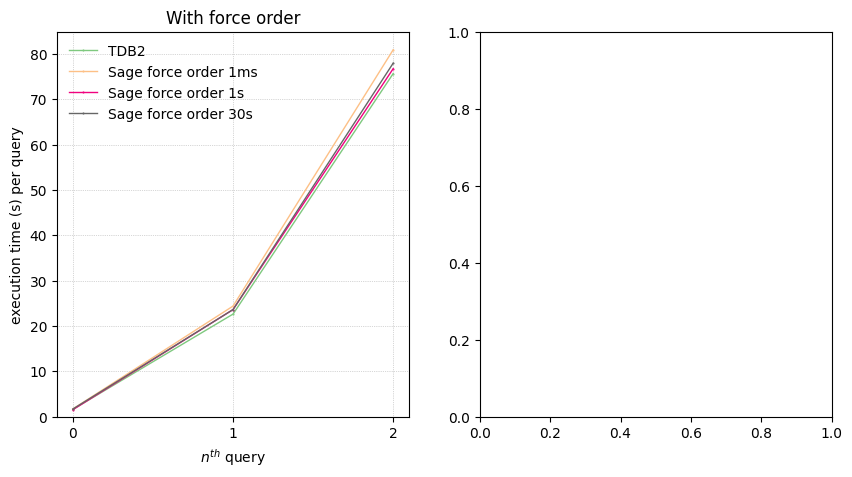

In [3]:
title_to_csv = readFiles(["Medium"])

allColumnsToFloat(title_to_csv, "Score")
allAndOnlyMode(title_to_csv, "ss")

no_force_order_df = baseline(title_to_csv, [""], ["force order"])
force_order_df = baseline(title_to_csv, ["force order"])

plotGraphs([no_force_order_df, force_order_df], ["Without force order", "With force order"], "s")

Again, Sage and TDB2 are on par.

# Long queries

Not many long queries.

WatdivBenchmark-Sage force order 30s-Long.csv
WatdivBenchmark-Sage force order 1ms-Long.csv
WatdivBenchmark-Sage force order 1s-Long.csv
WatdivBenchmark-TDB force order-Long.csv
WatdivBenchmark-Sage force order 30s-Long.csv
WatdivBenchmark-Sage force order 1ms-Long.csv
WatdivBenchmark-Sage force order 1s-Long.csv
WatdivBenchmark-TDB force order-Long.csv


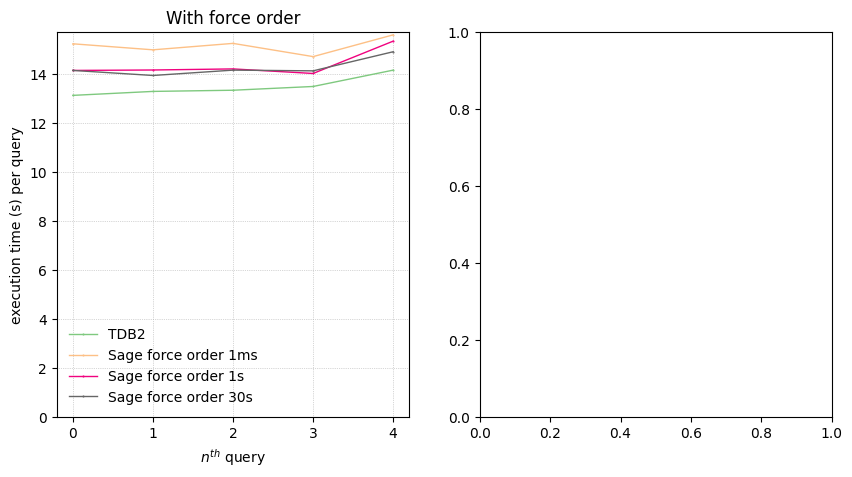

In [4]:
title_to_csv = readFiles(["Long"])

allColumnsToFloat(title_to_csv, "Score")
allAndOnlyMode(title_to_csv, "ss")

no_force_order_df = baseline(title_to_csv, [""], ["force order"])
force_order_df = baseline(title_to_csv, ["force order"])

plotGraphs([no_force_order_df, force_order_df], ["Without force order", "With force order"], "s")

In [5]:
## (TODO) A function that automatically run a benchmark on a query and place it on the graph